2024-12-24 07:52:09,457 - INFO - Initializing the Hybrid Quantum-Classical Neural Network
2024-12-24 07:52:09,457 - INFO - Initializing Data Loaders
2024-12-24 07:52:09,458 - INFO - Loading dataset from directory: /Users/sahajrajmalla/Documents/nepali-quantum-mnist/data/numerals
2024-12-24 07:52:09,474 - INFO - Loaded 2880 samples.
2024-12-24 07:52:09,476 - INFO - Data Loaders initialized successfully: 2304 training samples, 576 testing samples
2024-12-24 07:52:09,478 - INFO - Model architecture:
HybridModel(
  (fc1): Linear(in_features=784, out_features=2, bias=True)
  (quantum): QuantumLayer()
  (fc2): Linear(in_features=2, out_features=10, bias=True)
)
2024-12-24 07:52:09,479 - INFO - Starting training process
2024-12-24 07:52:09,480 - INFO - Starting training for 10 epochs
Epoch 1/10:   0%|          | 0/72 [00:00<?, ?it/s]/var/folders/zz/qg9mqbp56631kxmjjyl11f1h0000gn/T/ipykernel_12686/2525840487.py:161: DeprecationWarning: The return type of saved statevectors has been changed fro

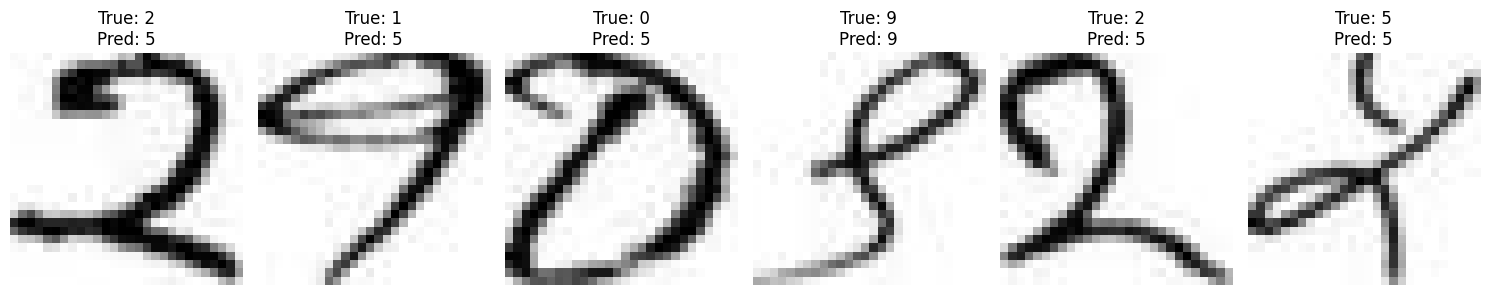

2024-12-24 07:56:09,424 - INFO - Visualization complete
2024-12-24 07:56:09,425 - INFO - Hybrid Quantum-Classical Neural Network execution completed


In [1]:
# hybrid_quantum_classical_nn.py

import os
import logging
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from matplotlib import pyplot as plt
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Pauli
from PIL import Image
from tqdm import tqdm  # For progress bars

# Setting up logging
def setup_logging(log_file='training.log'):
    """
    Sets up logging to output to both console and a file with a specific format.
    Args:
        log_file (str): Filename for the log file.
    """
    logger = logging.getLogger('HybridQuantumClassicalNN')
    logger.setLevel(logging.INFO)

    # Create handlers
    c_handler = logging.StreamHandler()
    f_handler = logging.FileHandler(log_file, mode='w')

    c_handler.setLevel(logging.INFO)
    f_handler.setLevel(logging.INFO)

    # Create formatter and add it to handlers
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    c_handler.setFormatter(formatter)
    f_handler.setFormatter(formatter)

    # Add handlers to the logger
    if not logger.handlers:
        logger.addHandler(c_handler)
        logger.addHandler(f_handler)

    return logger

logger = setup_logging()

# Define Dataset Class
class NepaliMNISTDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images organized in subdirectories per class.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []

        logger.info("Loading dataset from directory: %s", root_dir)
        for label in range(10):
            label_dir = os.path.join(root_dir, str(label))
            if not os.path.isdir(label_dir):
                logger.warning("Directory for label %d does not exist: %s", label, label_dir)
                continue
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                if os.path.isfile(img_path) and img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    self.data.append(img_path)
                    self.labels.append(label)
        logger.info("Loaded %d samples.", len(self.data))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = Image.open(self.data[idx]).convert('L')  # Convert to grayscale
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data Transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Paths
ROOT_DIR = "/Users/sahajrajmalla/Documents/nepali-quantum-mnist/data/numerals"  # Update this path as needed

def initialize_data_loaders(root_dir, batch_size=32):
    """
    Initializes and returns the training and testing data loaders.
    Args:
        root_dir (str): Root directory of the dataset.
        batch_size (int): Number of samples per batch.
    Returns:
        Tuple[DataLoader, DataLoader]: Training and testing data loaders.
    """
    logger.info("Initializing Data Loaders")
    dataset = NepaliMNISTDataset(root_dir=root_dir, transform=transform)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    logger.info("Data Loaders initialized successfully: %d training samples, %d testing samples", train_size, test_size)
    return train_loader, test_loader

# Implementing the Custom Quantum Layer
class QuantumLayerFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, params):
        """
        Forward pass for the quantum layer.
        Args:
            input (Tensor): Input tensor of shape (batch_size, num_inputs)
            params (Tensor): Parameter tensor for the quantum gates
        Returns:
            Tensor: Expectation values from the quantum circuit
        """
        # Convert tensors to numpy arrays
        input = input.detach().cpu().numpy()
        params = params.detach().cpu().numpy()

        batch_size, num_qubits = input.shape
        exp_z_batch = []

        for b in range(batch_size):
            circuit = QuantumCircuit(num_qubits)

            # Encode input data into quantum circuit using Ry rotations
            for i in range(num_qubits):
                # Ensure theta is a scalar float
                theta = float(input[b, i] * np.pi)
                circuit.ry(theta, i)

            # Apply parameterized Ry rotations
            for i in range(num_qubits):
                theta = float(params[i] * np.pi)
                circuit.ry(theta, i)

            # Measure expectation values of Z on each qubit
            backend = Aer.get_backend('statevector_simulator')
            job = execute(circuit, backend)
            result = job.result()
            state = result.get_statevector(circuit)

            # Compute expectation values
            exp_z = []
            for i in range(num_qubits):
                pauli_str = 'I' * i + 'Z' + 'I' * (num_qubits - i - 1)
                pauli = Pauli(pauli_str)
                # Ensure both operands are numpy arrays
                exp = np.real(state.conj().T @ pauli.to_matrix() @ state.data)
                exp_z.append(exp)
            exp_z_batch.append(exp_z)

        # Convert to tensor
        output = torch.tensor(exp_z_batch, dtype=torch.float32)

        ctx.save_for_backward(torch.tensor(input), torch.tensor(params))
        return output

    @staticmethod
    def backward(ctx, grad_output):
        """
        Backward pass using parameter-shift rule for gradients.
        Args:
            grad_output (Tensor): Gradient of the loss w.r.t. the output
        Returns:
            Tuple: Gradients w.r.t. the input and parameters
        """
        input, params = ctx.saved_tensors
        input = input.numpy()
        params = params.numpy()
        batch_size, num_qubits = input.shape
        delta = np.pi / 2  # Shift for parameter-shift

        grad_params = np.zeros_like(params)

        for i in range(num_qubits):
            for b in range(batch_size):
                # Shift parameters
                params_plus = np.copy(params)
                params_minus = np.copy(params)
                params_plus[i] += delta
                params_minus[i] -= delta

                # Compute forward pass for shifted parameters
                circuit_plus = QuantumCircuit(num_qubits)
                for j in range(num_qubits):
                    theta = float(input[b, j] * np.pi)
                    circuit_plus.ry(theta, j)
                for j in range(num_qubits):
                    theta = float(params_plus[j] * np.pi)
                    circuit_plus.ry(theta, j)
                job_plus = execute(circuit_plus, Aer.get_backend('statevector_simulator'))
                result_plus = job_plus.result()
                state_plus = result_plus.get_statevector(circuit_plus)

                # Expectation for i-th qubit
                pauli_str = 'I' * i + 'Z' + 'I' * (num_qubits - i -1)
                pauli = Pauli(pauli_str)
                exp_z_plus = np.real(state_plus.conj().T @ pauli.to_matrix() @ state_plus.data)

                circuit_minus = QuantumCircuit(num_qubits)
                for j in range(num_qubits):
                    theta = float(input[b, j] * np.pi)
                    circuit_minus.ry(theta, j)
                for j in range(num_qubits):
                    theta = float(params_minus[j] * np.pi)
                    circuit_minus.ry(theta, j)
                job_minus = execute(circuit_minus, Aer.get_backend('statevector_simulator'))
                result_minus = job_minus.result()
                state_minus = result_minus.get_statevector(circuit_minus)

                # Expectation for i-th qubit
                exp_z_minus = np.real(state_minus.conj().T @ pauli.to_matrix() @ state_minus.data)

                # Compute derivative
                derivative = (exp_z_plus - exp_z_minus) / 2
                grad_params[i] += derivative * grad_output[b, i]

        # Normalize grad_params by batch_size if needed
        grad_params /= batch_size

        # No gradients w.r.t. input in this simple example
        grad_input = None
        grad_params = torch.tensor(grad_params, dtype=torch.float32)
        return grad_input, grad_params

class QuantumLayer(nn.Module):
    def __init__(self, num_qubits=2):
        super(QuantumLayer, self).__init__()
        self.num_qubits = num_qubits
        # Initialize parameters for the quantum gates
        self.params = nn.Parameter(torch.randn(num_qubits) * 0.1)

    def forward(self, x):
        return QuantumLayerFunction.apply(x, self.params)

# Building the Hybrid Neural Network
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 2)  # Output matches number of qubits
        self.quantum = QuantumLayer(num_qubits=2)
        self.fc2 = nn.Linear(2, 10)       # Output for 10 classes

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.quantum(x)
        x = self.fc2(x)
        return x

# Training and Evaluation Functions
def train_model(model, train_loader, optimizer, loss_fn, epochs):
    """
    Trains the model for a specified number of epochs.
    Args:
        model (nn.Module): The neural network model.
        train_loader (DataLoader): DataLoader for training data.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        loss_fn (nn.Module): Loss function.
        epochs (int): Number of training epochs.
    """
    logger.info("Starting training for %d epochs", epochs)
    model.train()
    for epoch in range(1, epochs + 1):
        epoch_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch}/{epochs}', leave=False)
        for images, labels in progress_bar:
            images = images.view(-1, 28*28)  # Flatten the image
            labels = labels.long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix({'Loss': loss.item()})
        avg_loss = epoch_loss / len(train_loader)
        logger.info(f"Epoch {epoch}/{epochs} - Average Loss: {avg_loss:.4f}")

def evaluate_model(model, test_loader):
    """
    Evaluates the model on the test dataset and returns the accuracy.
    Args:
        model (nn.Module): The neural network model.
        test_loader (DataLoader): DataLoader for testing data.
    Returns:
        float: Accuracy percentage.
    """
    logger.info("Starting evaluation")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Evaluating', leave=False):
            images = images.view(-1, 28*28)  # Flatten the image
            labels = labels.long()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    logger.info(f"Evaluation completed with Accuracy: {accuracy:.2f}%")
    return accuracy

def visualize_predictions(model, test_loader, num_images=6):
    """
    Visualizes a few predictions from the model.
    Args:
        model (nn.Module): The neural network model.
        test_loader (DataLoader): DataLoader for testing data.
        num_images (int): Number of images to visualize.
    """
    logger.info("Visualizing predictions")
    model.eval()
    images, labels = next(iter(test_loader))
    images = images.view(-1, 28*28)
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for idx, ax in enumerate(axes):
        if idx >= len(images):
            break
        image = images[idx].numpy().reshape(28, 28)
        ax.imshow(image, cmap='gray')
        ax.set_title(f"True: {labels[idx].item()}\nPred: {predictions[idx].item()}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    logger.info("Visualization complete")

# Main execution
def main():
    logger.info("Initializing the Hybrid Quantum-Classical Neural Network")
    train_loader, test_loader = initialize_data_loaders(ROOT_DIR)

    model = HybridModel()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    logger.info("Model architecture:\n%s", model)
    logger.info("Starting training process")
    train_model(model, train_loader, optimizer, loss_fn, epochs=10)

    logger.info("Starting evaluation on test data")
    accuracy = evaluate_model(model, test_loader)
    logger.info(f"Test Accuracy: {accuracy:.2f}%")

    logger.info("Starting visualization of predictions")
    visualize_predictions(model, test_loader)

    logger.info("Hybrid Quantum-Classical Neural Network execution completed")

if __name__ == "__main__":
    main()
